<p style="font-size:34px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

<h1>1. Libraries</h1>

In [28]:
import warnings
warnings.filterwarnings("ignore")

# Data structures:
import pandas as pd
import numpy as np

# Visuals:
import matplotlib.pylab as plt
import seaborn as sns

# Models:
import xgboost as xgb

# Models metrics:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

# Parameter tuning:
from sklearn.model_selection import RandomizedSearchCV

# Mscellaneous:
from tqdm import tqdm

<h1>2. Reading Data</h1>

In [2]:
df_final_train = pd.read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = pd.read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns.values

array(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6'], dtype=object)

<h1>3. Additional Features</h1>

<h2>3.1 Preferential Attachment</h2>

###### One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity

In [4]:
df_final_train['preferentialattachment'] = df_final_train.loc[:,['num_followers_s']].values*df_final_train.loc[:,['num_followers_d']].values

In [5]:
df_final_test['preferentialattachment'] = df_final_test.loc[:,['num_followers_s']].values*df_final_test.loc[:,['num_followers_d']].values

<h2>3.2 svd_dot</h2>

###### calculate svd_dot as Dot product between sourse node svd and destination node svd features

In [6]:
source_svd = np.array(df_final_train.loc[:,['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 
                                            'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])

In [7]:
dest_svd = np.array(df_final_train.loc[:,['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 
                                          'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']])

Create dictionary that stores the svd_dot value for each observation

In [8]:
dic = dict()
for i in df_final_train.index.values:
    dic[i] = source_svd[i]@dest_svd[i]

Add empty column to the dataframe

In [9]:
df_final_train['svd_dot'] = np.zeros(len(df_final_train.index.values))

Update each row item with the value from the dictionary

In [10]:
for i in tqdm(dic.keys()):
    df_final_train.loc[i,'svd_dot'] = dic.get(i,0)

100%|████████████████████████████████████████████████████████████████████████| 100002/100002 [00:39<00:00, 2512.97it/s]


In [11]:
source_svd = np.array(df_final_test.loc[:,['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 
                                            'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])

In [12]:
dest_svd = np.array(df_final_test.loc[:,['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 
                                          'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']])

In [13]:
dic = dict()
for i in df_final_test.index.values:
    dic[i] = source_svd[i]@dest_svd[i]

In [14]:
df_final_test['svd_dot'] = np.zeros(len(df_final_test.index.values))

In [15]:
for i in tqdm(dic.keys()):
    df_final_test.loc[i,'svd_dot'] = dic.get(i,0)

100%|██████████████████████████████████████████████████████████████████████████| 50002/50002 [00:16<00:00, 3017.54it/s]


Create the response variable features

In [16]:
y_train = df_final_train.loc[:,'indicator_link']
y_test = df_final_test.loc[:,'indicator_link']

Remove unwanted features from X

In [17]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

<h1>4. Training XG Boost Model</h1>

Create xg boost model

In [18]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', n_jobs=-1, random_state=10)

Define a set of parameter values

In [19]:
param_set = {'max_depth':[3,5,10,15,20,50,100],
             'learning_rate':[0.0001,0.001,0.01,0.1,1,10,100,1000],
             'gamma':[0.001,0.01,0.1,1],
             'n_estimators':[5,10,15,20,50,100,200,400]}

Perform 10 randomized search values (models)

In [20]:
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_set, 
                                   n_iter=10, 
                                   scoring='f1', 
                                   n_jobs=-1, cv=10, 
                                   verbose=0, 
                                   random_state=10)

In [21]:
random_search.fit(df_final_train,y_train);

Obtain the train and CV metric results

In [22]:
train_scores = random_search.cv_results_.get('mean_train_score')
cv_scores = random_search.cv_results_.get('mean_test_score')

The graph below shows that the model performed well on both train and cv data sets

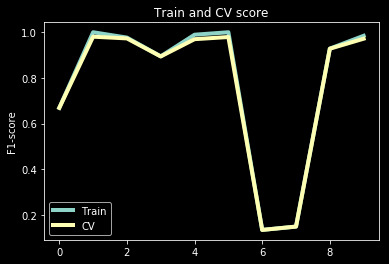

In [23]:
plt.style.use(['dark_background'])
plt.title('Train and CV score')
plt.plot(train_scores,linewidth=4,label='Train')
plt.plot(cv_scores,linewidth=4,label='CV')
plt.ylabel('F1-score')
plt.legend()
plt.show()

In [24]:
y_train_pred = random_search.predict(df_final_train)
y_test_pred = random_search.predict(df_final_test)

c:\users\byron\applications\pythonmaster\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\byron\applications\pythonmaster\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<h1>5. Performance Metrics</h1>

<h2>5.1 F1-Score</h2>

The model perfromed fairly well on the "unseen" dataset and on the train dataset

In [25]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9257568070353458


<h2>5.2 Confusion Matrix</h2>

In [26]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


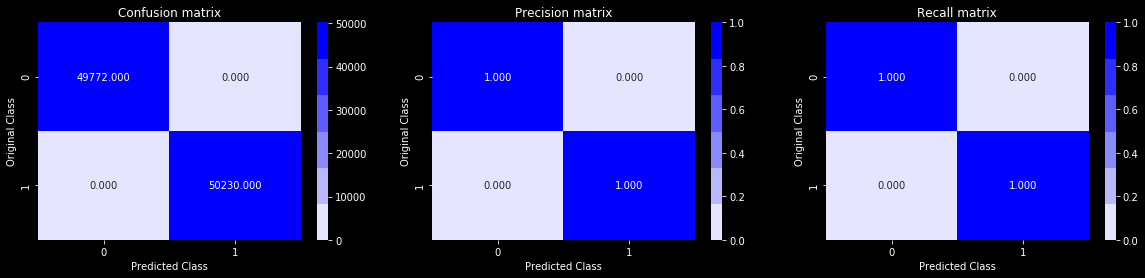

Test confusion_matrix


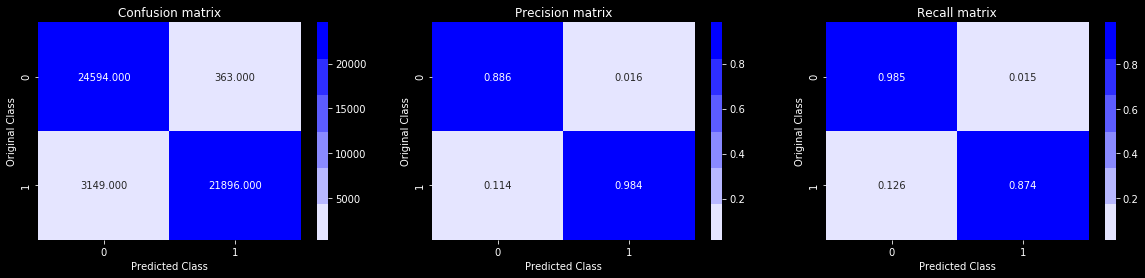

In [29]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

<h2>5.3 ROC-Curve and AUC</h2>

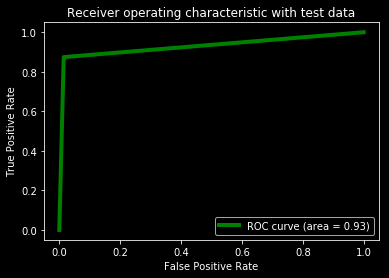

In [30]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.style.use(['dark_background'])
plt.title('Receiver operating characteristic with test data')
plt.plot(fpr, tpr, color='g',linewidth=4,label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<h1>6. Model interpretability</h1>

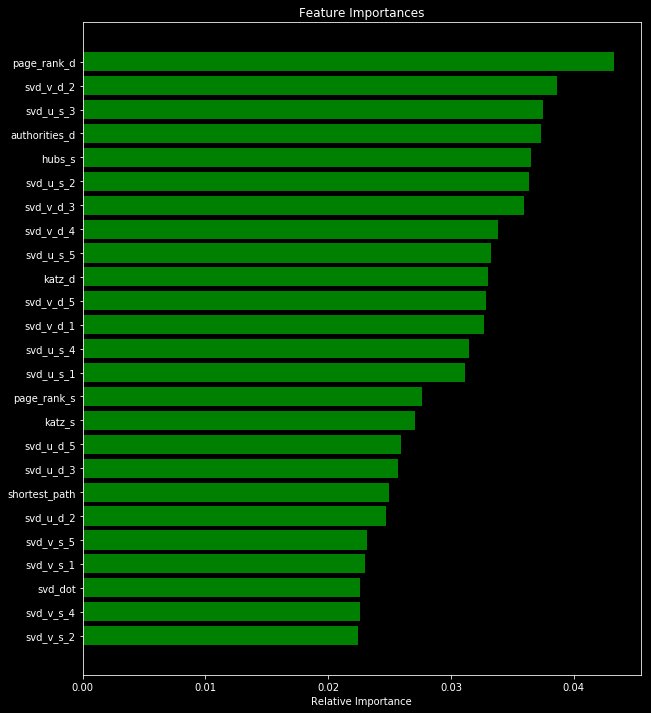

In [31]:
features = df_final_train.columns
importances = random_search.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()